<a href="https://colab.research.google.com/github/jithinmjoison/fast_ai_from_foundations/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Autoencoder
from IPython import get_ipython
from IPython.display import display
# %%
# Autoencoder

from tensorflow.keras import layers, models, datasets, callbacks
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf # fixed import
import tensorflow.keras.backend as K


In [2]:
### Paramaters for Auto Encoder

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [4]:
### Data Prep

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
### Function to Pre-process the data

def preprocess_image(imgs):
  """
  normalise the reshape Image
  """

  imgs = imgs.astype("float32")/255.0
  imgs = np.pad(imgs, ((0,0),(2,2),(2,2)), constant_values =0.0)
  imgs = np.expand_dims(imgs,-1)
  return imgs

In [6]:
x_train = preprocess_image(x_train)
x_test = preprocess_image(x_test)

In [7]:
display(x_train)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [20]:
### Building the autoencoder

encoder_input = layers.Input(shape =(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name = 'encoding_input')

x = layers.Conv2D(32,(3,3), strides = 2, padding= 'same', activation = 'relu')(encoder_input)

x = layers.Conv2D(64,(3,3), strides = 2, padding= 'same', activation = 'relu')(x)

x = layers.Conv2D(128,(3,3), strides = 2, padding= 'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

encoder_output = layers.Dense(EMBEDDING_DIM, name = 'encoding_output')(x)

encoder = models.Model(encoder_input, encoder_output)

encoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoding_input (InputLayer  [(None, 32, 32, 1)]       0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 encoding_output (Dense)     (None, 2)                 4098      
                                                           

In [21]:
### Building the Decoder
decoder_input = layers.Input(shape = (EMBEDDING_DIM,), name = 'decoding_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

x= layers.Reshape(shape_before_flattening)(x)

x= layers.Conv2DTranspose(128,(3,3), strides = 2, padding= 'same', activation = 'relu')(x)

x= layers.Conv2DTranspose(64,(3,3), strides = 2, padding= 'same', activation = 'relu')(x)

x=  layers.Conv2DTranspose(32,(3,3), strides = 2, padding= 'same', activation = 'relu')(x)

decoder_output = layers.Conv2DTranspose(CHANNELS,(3,3), strides = 1, padding= 'same', activation = 'sigmoid',name = 'decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

decoder = models.Model(decoder_input, decoder_output)

decoder.summary()



Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoding_input (InputLayer  [(None, 2)]               0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                           

In [22]:
### Autoencoder

autoencoder = models.Model(encoder_input, decoder(encoder(encoder_input)))
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoding_input (InputLayer  [(None, 32, 32, 1)]       0         
 )                                                               
                                                                 
 model_8 (Functional)        (None, 2)                 96770     
                                                                 
 model_10 (Functional)       (None, 32, 32, 1)         246273    
                                                                 
Total params: 343043 (1.31 MB)
Trainable params: 343043 (1.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
## Train the autoencoder

autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [24]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


In [25]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - 174s 287ms/step - loss: 0.1898 - val_loss: 0.1577
Epoch 2/3
600/600 [==============================] - 172s 288ms/step - loss: 0.1525 - val_loss: 0.1479
Epoch 3/3
600/600 [==============================] - 163s 272ms/step - loss: 0.1461 - val_loss: 0.1443


In [27]:
###saving the final model
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")


In [29]:
### Reconstruct using the Auto Encoder
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]



In [30]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 [==============================] - 5s 32ms/step
Example real clothing items


array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

Reconstructions


array([[[[2.45585488e-06],
         [2.03674908e-08],
         [1.74945285e-08],
         ...,
         [4.58789118e-11],
         [8.59237542e-11],
         [3.91263086e-07]],

        [[9.75702186e-10],
         [1.25181397e-12],
         [7.28196149e-13],
         ...,
         [2.50128660e-15],
         [3.15444112e-15],
         [1.07544862e-09]],

        [[2.94176211e-10],
         [1.17876344e-13],
         [8.69033036e-14],
         ...,
         [2.45075621e-15],
         [7.15863204e-15],
         [8.61535454e-10]],

        ...,

        [[5.77932258e-10],
         [5.60418519e-13],
         [2.99733057e-13],
         ...,
         [1.34045986e-11],
         [2.43801810e-12],
         [5.61026070e-09]],

        [[3.67843556e-09],
         [3.57023786e-12],
         [4.63759760e-12],
         ...,
         [2.68210107e-12],
         [1.79710576e-12],
         [6.82545664e-09]],

        [[1.39513202e-06],
         [4.69386698e-08],
         [5.67634117e-08],
         ...,
 

In [31]:
### Embed using the encoder

embeddings = encoder.predict(example_images)

157/157 [==============================] - 1s 6ms/step


In [32]:
# Some examples of the embeddings
print(embeddings[:10])

[[-0.88491935 -2.2124236 ]
 [-1.5182458   1.0864961 ]
 [-3.016158   -5.4304614 ]
 [ 1.389676   -0.30102095]
 [-1.1951715  -1.0853907 ]
 [-2.7875905  -5.2642956 ]
 [-1.2350888  -1.4229517 ]
 [-1.917178   -0.79897803]
 [-0.20271899 -0.5852437 ]
 [-0.5925083  -2.5708623 ]]


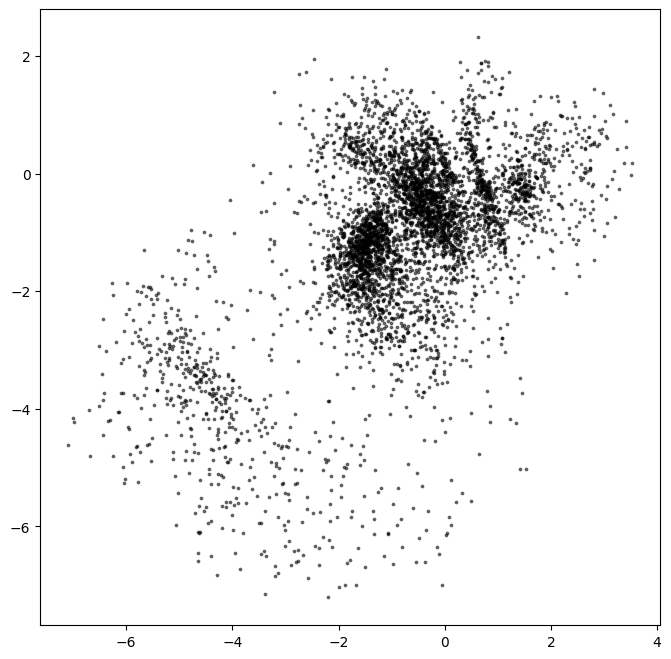

In [33]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

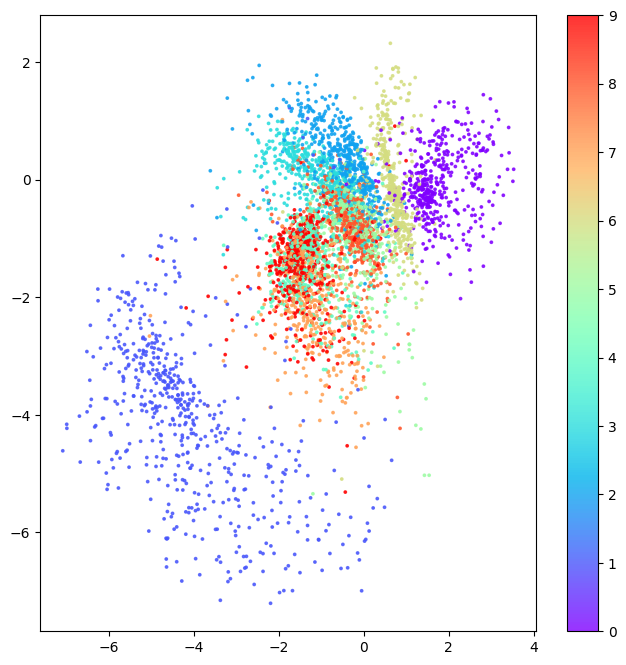

In [34]:
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [36]:
### Genearte using Decoder ###

# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [37]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 175ms/step


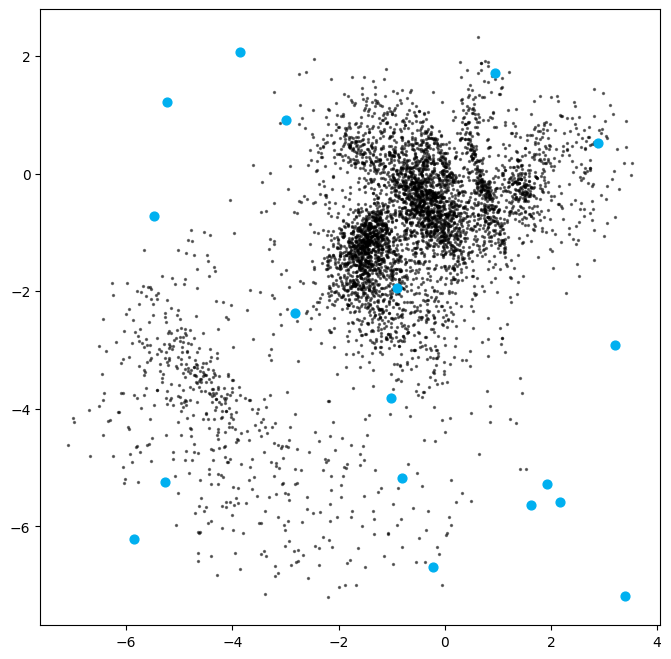

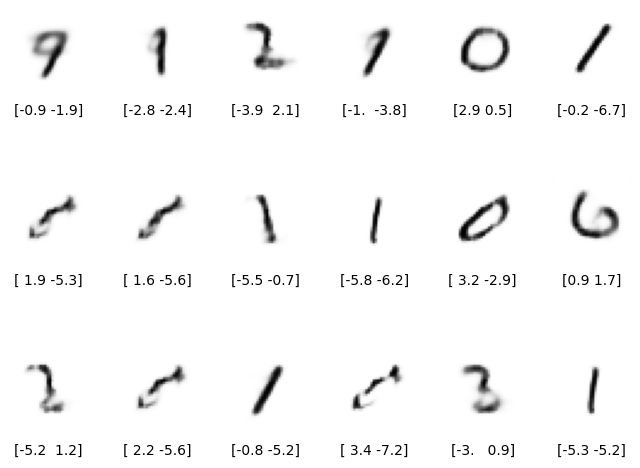

In [38]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 29ms/step


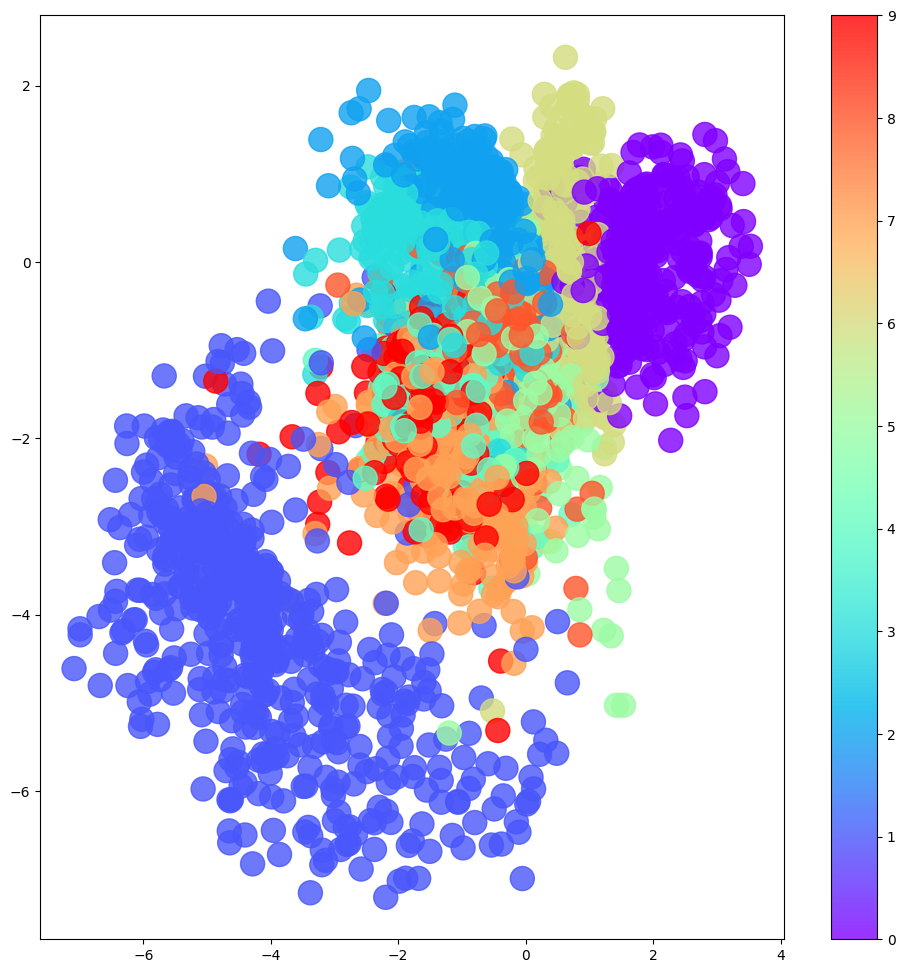

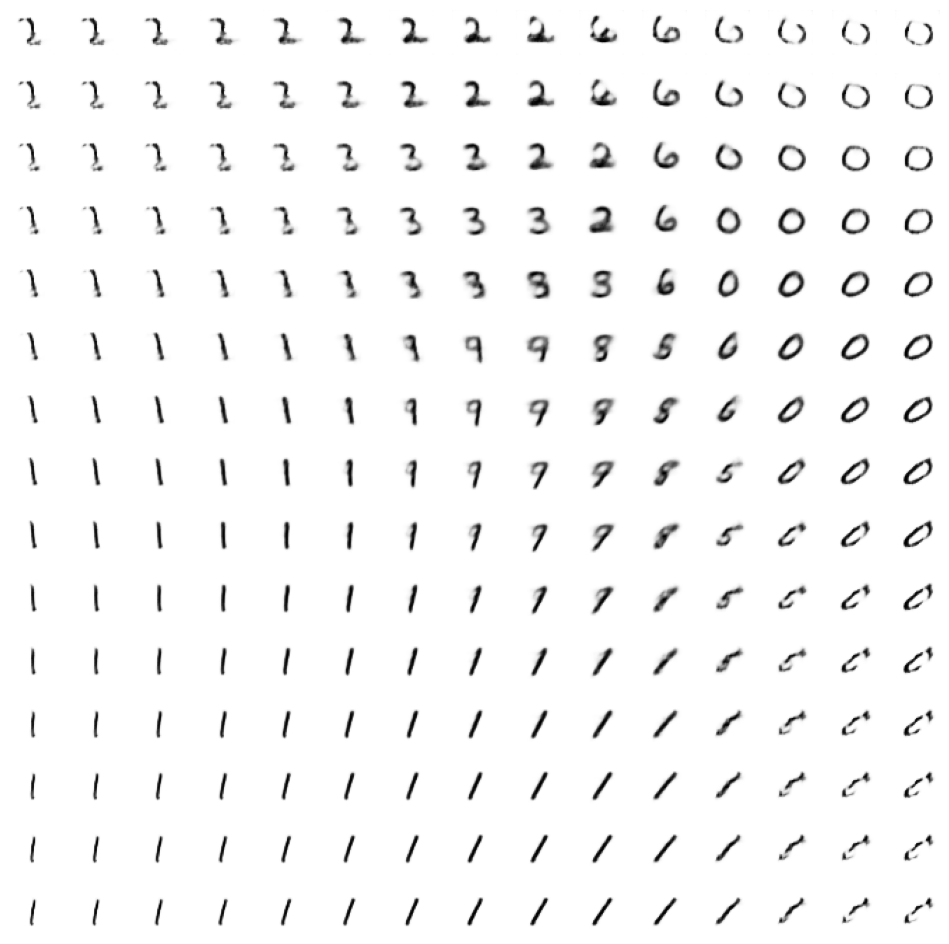

In [39]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")